In [157]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [158]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

# INTRODUCTION
   
The goal of this competition is to predict the category of crime given time and location within the city of San Francisco, using nearly 12 years of past crime data. The models employed and in this project include DecisionTree, RandomForest, and SVM with their performance comparison is based on the analysis of the corresponding confusion matrice.

In [160]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
import xgboost
from xgboost import XGBClassifier

# EDA

Lets start by visualising the datasets in pandas

In [163]:
test_df = pd.read_csv("test.csv", index_col='Id')
df_train = pd.read_csv("train.csv")

In [164]:
df_train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [165]:
#Check what columns are present in the test set.
df_train.columns

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y'],
      dtype='object')

We will check if the train set contains any null values or missing rows. The data looks fine here so no data cleaning needed.

In [167]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [168]:
df_train.describe()

,X,Y
count,878049.000000,878049.000000
mean,-122.422616,37.771020
std,0.030354,0.456893
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784369
max,-120.500000,90.000000


However, looking at the summary of X, Y columns, there seems to be an outlier. Most of the Y falls around the 37 range but there is one at 90. Lets remove the 90 from our dataset

In [170]:
buffer = df_train.copy()
buffer = buffer[buffer["Y"]<90]

<br>
Plot of Crime Locations

<Axes: xlabel='X', ylabel='Y'>

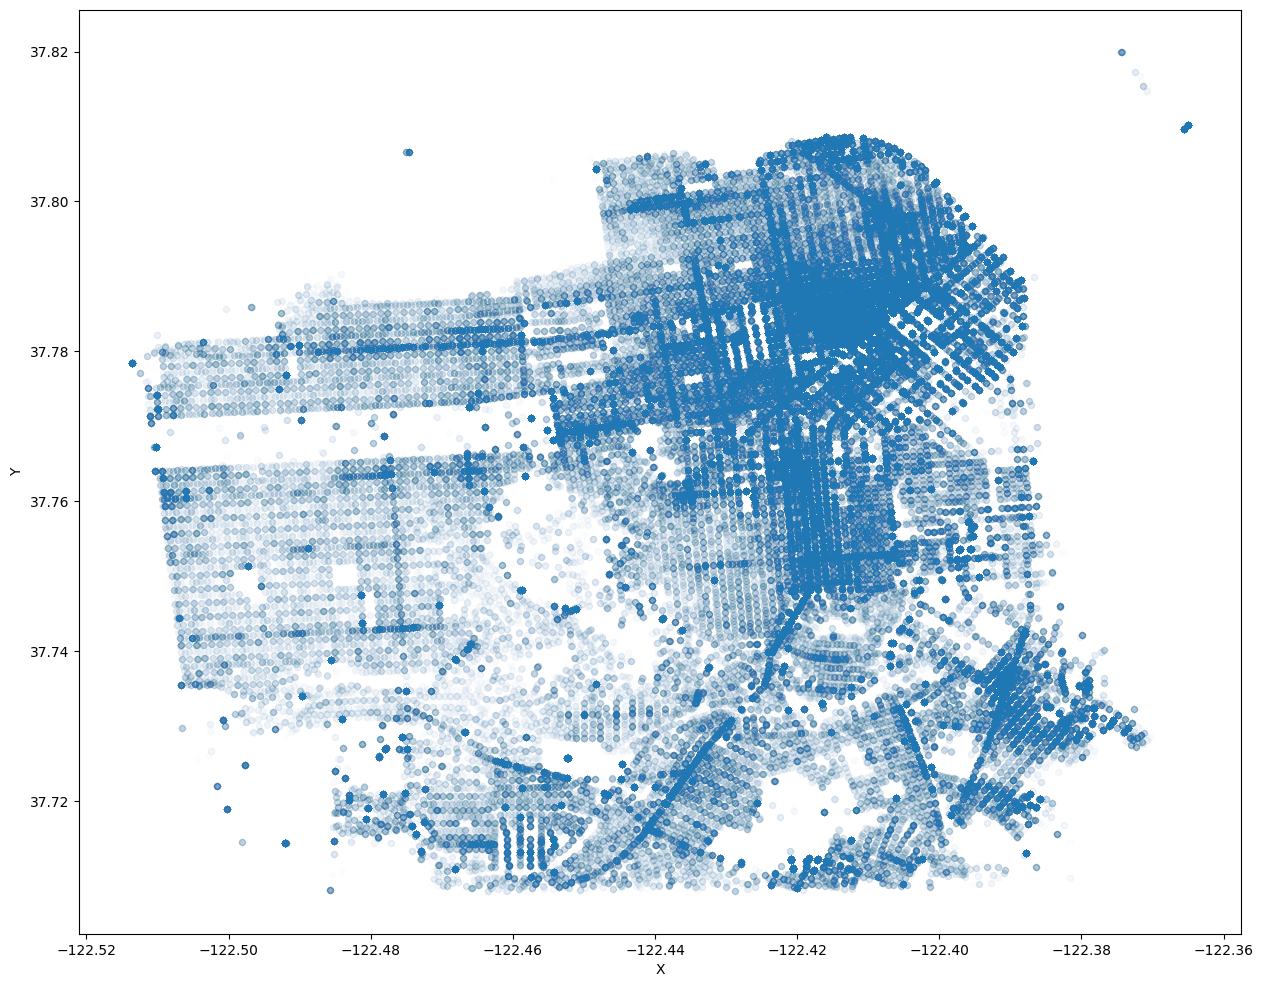

In [172]:
buffer.plot(x="X", y="Y", kind="scatter", alpha=0.01,figsize=(15,12))

<br>
Crime Category/Count 

In [174]:
buffer["Category"].value_counts()

Category
LARCENY/THEFT                  174885
OTHER OFFENSES                 126165
NON-CRIMINAL                    92300
ASSAULT                         76872
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53772
VANDALISM                       44724
WARRANTS                        42206
BURGLARY                        36754
SUSPICIOUS OCC                  31412
MISSING PERSON                  25989
ROBBERY                         22999
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7325
STOLEN PROPERTY                  4539
SEX OFFENSES FORCIBLE            4387
DISORDERLY CONDUCT               4318
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQ

<br>
Extract the Hour the crime occured from Dates and add to the dataset.

In [176]:
from datetime import datetime

buffer["Hour"] = buffer.Dates.apply(lambda date_string: date_string[11:-6])
buffer.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Hour
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,23
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,23
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,23
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,23
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,23


<br>
Crime totals based on DayOfWeek and Hour crime occurs. 

In [178]:
buffer.groupby(["DayOfWeek"])["Hour"].value_counts()

DayOfWeek  Hour
Friday     18      8711
           17      8381
           19      7785
           12      7774
           16      7658
                   ... 
Wednesday  02      2377
           06      2054
           03      1701
           05      1303
           04      1268
Name: count, Length: 168, dtype: int64

# PREPROCESSING

train data to include "DayOfWeek", "PdDistrict", "X", "Y", "Hour" as only columns and test data to get "Hour" as an extra column.

In [181]:
import numpy as np

train_full = buffer.copy()
X_train_full, y_train_full = np.array(train_full[["DayOfWeek", "PdDistrict", "X", "Y", "Hour"]]), np.array(train_full[["Category"]])
y_train_full = y_train_full.ravel()
X_test = test_df.copy()
X_test["Hour"] = X_test.Dates.apply(lambda date_string: date_string[11:-6])
X_test = X_test.drop(columns=["Dates", "Address"])
X_test = np.array(X_test)

In [182]:
X_train_full

array([['Wednesday', 'NORTHERN', -122.425891675136, 37.7745985956747,
        '23'],
       ['Wednesday', 'NORTHERN', -122.425891675136, 37.7745985956747,
        '23'],
       ['Wednesday', 'NORTHERN', -122.42436302145, 37.8004143219856,
        '23'],
       ...,
       ['Monday', 'SOUTHERN', -122.403390364804, 37.780265577696, '00'],
       ['Monday', 'SOUTHERN', -122.390531404187, 37.78060707982429, '00'],
       ['Monday', 'BAYVIEW', -122.394925721424, 37.738211541052, '00']],
      dtype=object)

Split the full training set into train and validation set. Stratified sampling is used to ensure that the training and val set containing all 39 categories.

In [184]:
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in sss.split(X_train_full, y_train_full):
  X_train, y_train = X_train_full[train_index], y_train_full[train_index]
  X_val, y_val = X_train_full[test_index], y_train_full[test_index]

Next, lets set a pipeline to preprocess the datasets. StandardScaler() to normalise the numerical atttributes and OneHotEncoder() to convert the categorical attributes to arrays.

In [186]:
num_attribs = [2,3]
cat_attribs = [0,1,4]

num_pipeline = Pipeline([
                         ('std_scaler', StandardScaler())
])

full_pipeline = ColumnTransformer([
                                 ('num', num_pipeline, num_attribs),
                                 ('cat', OneHotEncoder(), cat_attribs) 
])
X_train_prepared = full_pipeline.fit_transform(X_train)
X_val_prepared = full_pipeline.transform(X_val)
X_test_prepared = full_pipeline.transform(X_test)

# TRAIN MODELS (XGBOOST, RANDOMFOREST, SVM)

Scale down the train set from 658 486 rows to 100 000 using Stratified Sampling to cut down computer long run time problem.

In [189]:
ss = StratifiedShuffleSplit(n_splits=1, train_size=100_000, random_state=42)
for train_index, _ in ss.split(X_train_prepared, y_train):
  X_train_prepared_small, y_train_small = X_train_prepared[train_index], y_train[train_index].ravel()

X_train_prepared_small.shape, y_train_small.shape

((100000, 43), (100000,))

In [190]:
y_train_small

array(['OTHER OFFENSES', 'NON-CRIMINAL', 'ASSAULT', ..., 'ASSAULT',
       'LARCENY/THEFT', 'DRUG/NARCOTIC'], dtype=object)

<br>
Ensemble to include XGBoost and RandomForest.

In [192]:
rf_clf = RandomForestClassifier(max_depth=16, random_state=42, n_jobs=-1, verbose=3)
xg_clf = xgboost.XGBClassifier()

estimators = [
            ("rf", rf_clf),
            ("xg", xg_clf)
]

voting_clf = VotingClassifier(estimators, n_jobs=-1, voting="soft")
voting_clf.fit(X_train_prepared_small, y_train_small)
#voting_clf.fit(X_train_prepared_small, y_train_small)
voting_clf.score(X_val_prepared, y_val)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.3s finished


0.26431005576411415

<br>
# SUBMISSION TO KAGGLE
Create the csv file for submission. 

In [194]:
y_pred = voting_clf.predict_proba(X_test_prepared)
pred_df = pd.DataFrame(y_pred, columns=[voting_clf.classes_])
pred_df["Id"]= list(range(pred_df.shape[0]))
pred_df.to_csv("crime_pred_02.zip", compression="zip", index=False)
pred_df.head()

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   12.8s finished


,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS,Id
0,0.002208,0.121337,0.000107,0.000296,0.022695,0.001476,0.002619,0.021124,0.002022,0.000683,...,0.014900,0.000080,0.027117,8.802302e-07,0.002501,0.085474,0.116644,0.051303,0.017444,0
1,0.005053,0.140535,0.000139,0.000805,0.014512,0.001585,0.005147,0.111952,0.002477,0.000241,...,0.002796,0.000087,0.024329,7.595439e-07,0.002640,0.054689,0.058472,0.078002,0.032643,1
2,0.000549,0.069496,0.000078,0.000028,0.083777,0.001775,0.003031,0.021884,0.007137,0.000330,...,0.003501,0.000727,0.024615,7.289237e-07,0.005326,0.061214,0.113157,0.023002,0.003676,2
3,0.002449,0.093267,0.000253,0.000257,0.015658,0.001234,0.002940,0.033991,0.002180,0.003237,...,0.006855,0.000523,0.025474,1.942466e-06,0.004338,0.064692,0.184946,0.036399,0.022132,3
4,0.002449,0.093267,0.000253,0.000257,0.015658,0.001234,0.002940,0.033991,0.002180,0.003237,...,0.006855,0.000523,0.025474,1.942466e-06,0.004338,0.064692,0.184946,0.036399,0.022132,4


# GENERATE CONFUSION MATRICES (XGBOOST, RANDOMFOREST, SVM)

In [196]:
from sklearn.svm import SVC
svm_clf = SVC(kernel='linear')
#xg_clf = xgboost.XGBClassifier()
#rf_clf = RandomForestClassifier()
#rf_model = xg_clf.fit(X_train_prepared_small, y_train_small)
svm_model = svm_clf.fit(X_train_prepared_small, y_train_small)

In [197]:
#y_val_preds = rf_model.predict_proba(X_val_prepared)
y_val_preds = svm_model.predict(X_val_prepared)
#y_val_preds_df = pd.DataFrame(y_val_preds, columns=[rf_clf.classes_])
#y_val_preds_df["Id"]= list(range(y_val_preds_df.shape[0]))

In [198]:
from sklearn.metrics import classification_report as cr
print(cr(y_val,y_val_preds))

                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00       378
                    ASSAULT       0.14      0.05      0.08     19218
                 BAD CHECKS       0.00      0.00      0.00       101
                    BRIBERY       0.00      0.00      0.00        72
                   BURGLARY       0.00      0.00      0.00      9189
         DISORDERLY CONDUCT       0.00      0.00      0.00      1080
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       567
              DRUG/NARCOTIC       0.22      0.33      0.27     13493
                DRUNKENNESS       0.00      0.00      0.00      1070
               EMBEZZLEMENT       0.00      0.00      0.00       292
                  EXTORTION       0.00      0.00      0.00        64
            FAMILY OFFENSES       0.00      0.00      0.00       123
     FORGERY/COUNTERFEITING       0.00      0.00      0.00      2652
                      FRAUD      

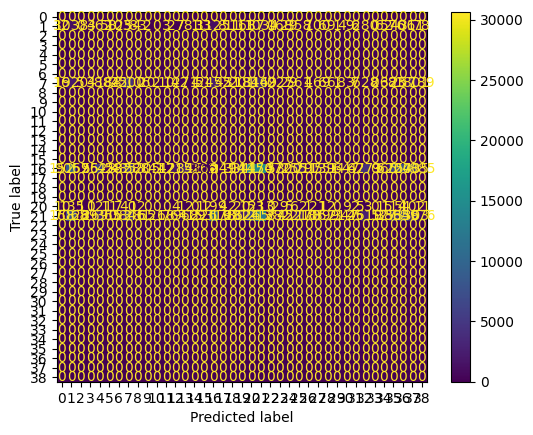

In [199]:
from sklearn.metrics import confusion_matrix as cm, ConfusionMatrixDisplay as cmd
tmp=cm(y_val_preds, y_val)
disp=cmd(tmp)
disp.plot()

In [200]:
rf_clf = RandomForestClassifier()
rf_model = rf_clf.fit(X_train_prepared_small, y_train_small)
y_val_preds = rf_model.predict(X_val_prepared)
#yval_preds = rf_model.predict_proba(X_test_prepared)

In [201]:
#y_val_preds_df = pd.DataFrame(y_test_preds, columns=[rf_clf.classes_])
#y_test_preds_df["Id"]= list(range(y_test_preds_df.shape[0]))
#y_test_preds_df.head()

In [202]:
from sklearn.metrics import classification_report as cr
print(cr(y_val,y_val_preds))

                             precision    recall  f1-score   support

                      ARSON       0.01      0.01      0.01       378
                    ASSAULT       0.14      0.13      0.13     19218
                 BAD CHECKS       0.00      0.00      0.00       101
                    BRIBERY       0.00      0.00      0.00        72
                   BURGLARY       0.08      0.06      0.07      9189
         DISORDERLY CONDUCT       0.04      0.03      0.03      1080
DRIVING UNDER THE INFLUENCE       0.02      0.01      0.01       567
              DRUG/NARCOTIC       0.25      0.26      0.25     13493
                DRUNKENNESS       0.01      0.01      0.01      1070
               EMBEZZLEMENT       0.01      0.00      0.00       292
                  EXTORTION       0.00      0.00      0.00        64
            FAMILY OFFENSES       0.02      0.02      0.02       123
     FORGERY/COUNTERFEITING       0.05      0.04      0.04      2652
                      FRAUD      

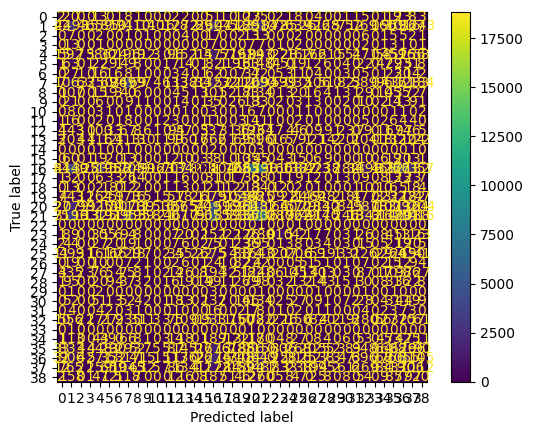

In [203]:
from sklearn.metrics import confusion_matrix as cm, ConfusionMatrixDisplay as cmd
tmp=cm(y_val_preds, y_val)
disp=cmd(tmp)
disp.plot()

In [204]:
from sklearn.tree import DecisionTreeClassifier
dt_clf  = DecisionTreeClassifier()
dt_model = dt_clf.fit(X_train_prepared_small, y_train_small)

In [205]:
y_val_preds = dt_model.predict(X_val_prepared)

In [206]:
print(cr(y_val,y_val_preds))

                             precision    recall  f1-score   support

                      ARSON       0.01      0.01      0.01       378
                    ASSAULT       0.14      0.16      0.15     19218
                 BAD CHECKS       0.00      0.00      0.00       101
                    BRIBERY       0.00      0.00      0.00        72
                   BURGLARY       0.09      0.09      0.09      9189
         DISORDERLY CONDUCT       0.04      0.05      0.05      1080
DRIVING UNDER THE INFLUENCE       0.02      0.02      0.02       567
              DRUG/NARCOTIC       0.24      0.28      0.26     13493
                DRUNKENNESS       0.02      0.02      0.02      1070
               EMBEZZLEMENT       0.01      0.01      0.01       292
                  EXTORTION       0.00      0.00      0.00        64
            FAMILY OFFENSES       0.02      0.02      0.02       123
     FORGERY/COUNTERFEITING       0.06      0.05      0.06      2652
                      FRAUD      

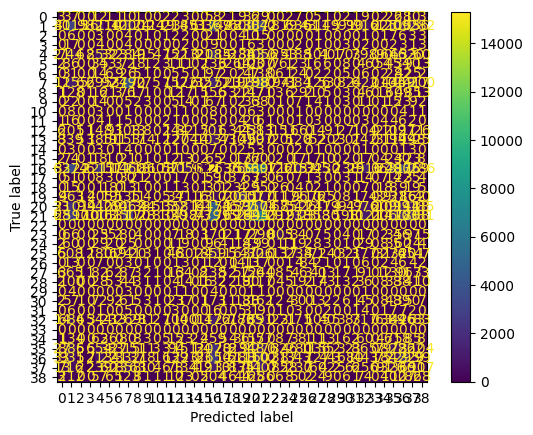

In [207]:
from sklearn.metrics import confusion_matrix as cm, ConfusionMatrixDisplay as cmd
tmp=cm(y_val_preds, y_val)
disp=cmd(tmp)
disp.plot()